# Parameter estimation example: fitting a straight line II
## Bayesian handling of nuisance parameters
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting

## The Data and the question

Let's start by defining some data that we will fit with a straight line.  The following data is measured velocities and distances for a set of galaxies. We will assume that there is a constant standard deviation of $\sigma = 200$ km/sec on the $y$ values and no error on $x$.

In [2]:
# Data from student lab observations; 
# d0 = Galaxy distances in MPc
# v0 = Galaxy velocity in km/sec
d0 = np.array([6.75, 25, 33.8, 9.36, 21.8, 5.58, 8.52, 15.1])
v0 = np.array([462, 2562, 2130, 750, 2228, 598, 224, 971])
# Assumed exp. uncertainty
err_v0 = 200

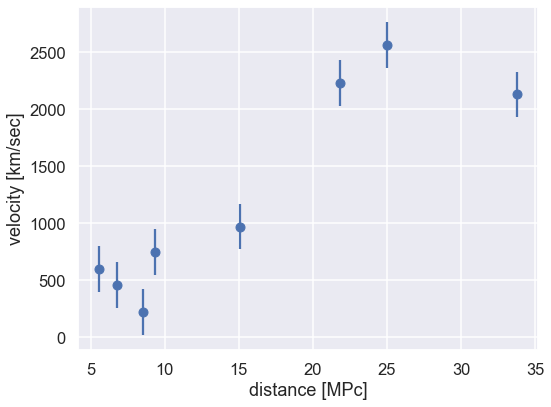

In [3]:
x=d0; y=v0; dy=err_v0
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel(r'distance [MPc]')
ax.set_ylabel(r'velocity [km/sec]')
fig.tight_layout()

The question that we will be asking is: 
> What value would you infer for the Hubble constant given this data?

We will make the prior assumption that the data can be fitted with a straight line (see also the [parameter_estimation_fitting_straight_line_I.ipynb](../Parameter_estimation/parameter_estimation_fitting_straight_line_I.ipynb) notebook). But we note that we are actually not interested in the offset of the straight line, but just its slope.

We will try three different approaches:
* Maximum likelihood estimate
* Single-parameter inference
* Full Bayesian analysis

As a final part of this notebook, we will also explore how the posterior belief from this analysis can feed into a second data analysis.

## The Model

We follow the procedure outlined in [parameter_estimation_fitting_straight_line_I.ipynb](../Parameter_estimation/parameter_estimation_fitting_straight_line_I.ipynb).

Thus, we're fitting a straight line to data, 

$$
y_M(x) = mx + b
$$

where our parameter vector will be 

$$
\theta = [b, m].
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only this expected value $y_M(x;\theta)$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $\pr(D\mid\theta)$ for our data as a function of the parameters $\theta$.

Here we are given data with simple error bars, which imply that the probability for any *single* data point is a normal distribution about the true value. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma)
$$

or, in other words,

$$
\pr(y_i\mid x_i,\theta) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$

where $\varepsilon_i$ are the (known) measurement errors indicated by the error bars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
\pr(D\mid\theta) = \prod_{i=1}^N \pr(x_i,y_i\mid\theta)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:

$$
\log \pr(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

## Step 1: Maximum likelihood estimate

In [4]:
# Log likelihood
def log_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         (y - y_model) ** 2 / dy ** 2)

Use tools in [``scipy.optimize``](http://docs.scipy.org/doc/scipy/reference/optimize.html) to maximize this likelihood (i.e. minimize the negative log-likelihood).

In [5]:
from scipy import optimize

def minfunc(theta, x, y, dy):
    """
    Function to be minimized: minus the logarithm of the likelihood
    """
    return -log_likelihood(theta, x, y, dy)

result = optimize.minimize(minfunc, x0=[0, 0], args=(x, y, dy))

The output from 'scipy.optimize' contains the set of parameters, and also the inverse of the hessian matrix (that measures the second-order curvature of the optimum). The inverse hessian is related to the covariance matrix. Very often you see the square root of the diagonal elements of this matrix as uncertainty estimates. We will not discuss this measure here, but refer to the highly recommended review: [Error estimates of theoretical models: a guide](https://iopscience.iop.org/article/10.1088/0954-3899/41/7/074001).

In [6]:
# Print the MLE and the square-root of the diagonal elements of the inverse hessian
print(f'Maximum Likelihood Estimate (MLE):')
ndim = len(result.x)
theta_MLE=result.x
err_theta_MLE = np.array([np.sqrt(result.hess_inv[i,i]) for i in range(ndim)])
for i in range(ndim):
    print(f'... theta[{i}] = {theta_MLE[i]:>5.1f} +/- {err_theta_MLE[i]:>5.1f}')

Maximum Likelihood Estimate (MLE):
... theta[0] = -26.7 +/- 136.6
... theta[1] =  80.5 +/-   7.4


## Step 2: Single-parameter model

As we are not interested in the offset parameter, we might be tempted to fix its value to the most-likely estimate and then infer our knowledge about the slope from a single-parameter model. You have probably realized by now that this is not the Bayesian way of doing the analysis, but since this is a rather common way of handling nuisance parameters, we will still try it.

In [7]:
offset = theta_MLE[0]

Let's define the log-likelihood for the case that the offset is fixed. It will be a function of a single free parameter: the slope.

In [8]:
# Log likelihood
def log_likelihood_single(slope, x, y, dy, offset=0.):
    y_model = offset + slope * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         (y - y_model) ** 2 / dy ** 2)

Next we will plot the log-likelihood (left panel) and the likelihood (right panel) pdfs as a function of the slope. We normalize the peak of the likelihood to one

Text(0.5, 0, 'slope')

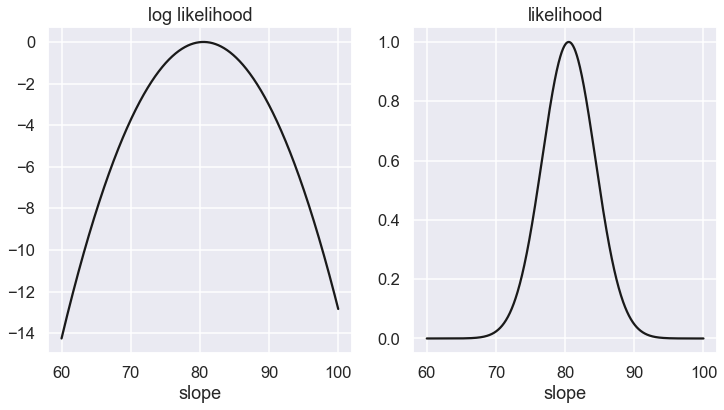

In [9]:
slope_range = np.linspace(60, 100, num=1000)
log_P1 = [log_likelihood_single(slope, x, y, dy,offset=offset) for slope in slope_range]
log_P1_1 = log_P1 - np.max(log_P1)

fig,ax = plt.subplots(1, 2, figsize=(12,6),sharex=True)

ax[0].plot(slope_range,log_P1_1,'-k');
ax[0].set_title('log likelihood')
ax[0].set_xlabel('slope')
ax[1].plot(slope_range,np.exp(log_P1_1),'-k');
ax[1].set_title('likelihood')
ax[1].set_xlabel('slope')


Single parameter estimate
... slope =  80.5 +/-   3.8


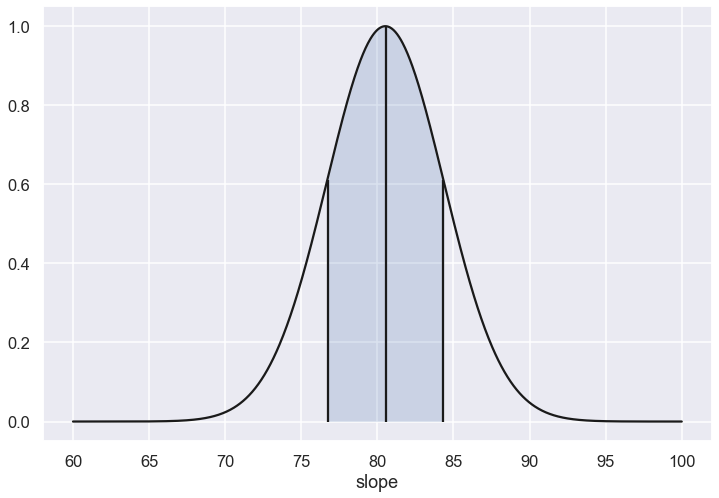

In [10]:
def contour_levels(grid,sigma):
    _sorted = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(_sorted) / np.sum(_sorted)
    cutoffs = np.searchsorted(pct, np.array(sigma) )
    return _sorted[cutoffs]

P1 = np.exp(log_P1 - np.max(log_P1))
sigma_contours = contour_levels(P1,0.68)

# Find the max likelihood and the 68% contours
slope_max = slope_range[P1==1.][0]
err_slope_min = np.min(slope_range[P1>sigma_contours])
err_slope_max = np.max(slope_range[P1>sigma_contours])

# The error will be symmetric around the max
err_slope = (err_slope_max - err_slope_min) / 2

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(slope_range,P1,'-k')
ax.set_xlabel('slope')
ax.vlines([err_slope_min,slope_max,err_slope_max],0,[sigma_contours,1.,sigma_contours])
ax.fill_between(slope_range, P1, where=P1>=sigma_contours, interpolate=True, alpha=0.2);

print('Single parameter estimate')
print(f'... slope = {slope_max:>5.1f} +/- {err_slope:>5.1f}')

## Step 3: Full Bayesian approach

You might not be surprised to learn that we underestimate the uncertainty of the slope since we are making the assumption that we know the value of the offset (by fixing it to a specific estimate).

We will now repeat the data analysis, but with the full model and with marginalization on the posterior.

Let's use the (log) symmetric prior, which is the scale-invariant one.

In [11]:
def log_prior(theta):
    # symmetric prior for the slope, and normal pdf (mean=0, variance=200) for the intercept
    return - 0.5* theta[0]**2 / dy**2 - 1.5 * np.log(1 + theta[1] ** 2) 

With these defined, we now have what we need to compute the log posterior as a function of the model parameters.

In [12]:
def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

Next we will plot the posterior probability as a function of the slope and intercept. 

We will illustrate the use of MCMC sampling for obtaining the posterior pdf, which also offers a very convenient way of performing the marginalization

In [13]:
import emcee
print('emcee sampling (version: )', emcee.__version__)

ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 2000 # steps per walker

print(f'{nwalkers} walkers: {nsteps} samples each')

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, dy])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

emcee sampling (version: ) 3.0.2
50 walkers: 2000 samples each
CPU times: user 3.68 s, sys: 23.2 ms, total: 3.7 s
Wall time: 3.72 s
done


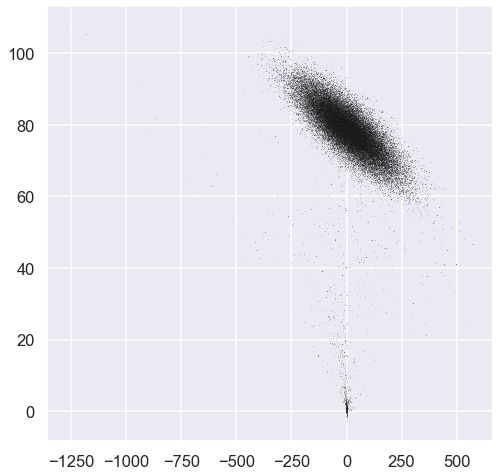

In [14]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# Let us reshape and all walker chains together
# Then make a scatter plot
emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);

Our choice of starting points were not optimal. It takes some time for the MCMC chains to converge. Let us study the traces.

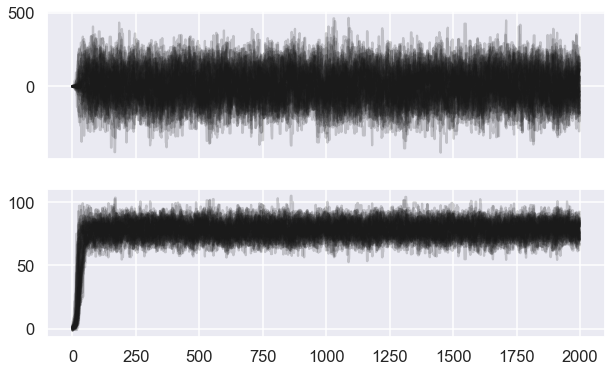

In [15]:
fig, ax = plt.subplots(ndim, sharex=True,figsize=(10,6))
for i in range(ndim):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

In [15]:
# We choose a warm-up time
nwarmup = 200 # warm up

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the warmup points and reshape:
emcee_trace = sampler.chain[:, nwarmup:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nwarmup:].reshape(-1).T

Let us create some convenience tools for plotting, including a machinery to extract 1-, 2-, 3-sigma contour levels.

We will later use the 'corner' package to achieve such visualization. 

In [16]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955, 0.997], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    
# Convenience function to extract the peak position of the mode
def max_of_mode(sampler_object):
    max_arg = np.argmax(sampler.flatlnprobability)
    return(sampler.flatchain[max_arg])

Max posterior is at: [ 4.04  78.554]


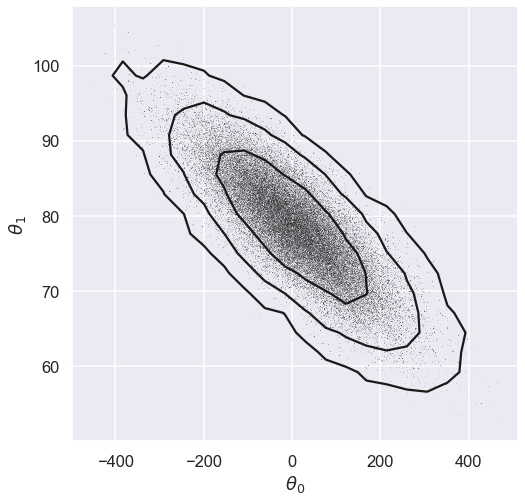

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plot_MCMC_trace(ax, x, y, emcee_trace, scatter=True,colors='k');
max_mode_theta=max_of_mode(sampler)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_theta}')

### Marginalization

Next we will perform the marginalization over the offset parameter using the samples from the posterior pdf. 

Furthermore, the extraction of a 68% credible region (not to be confused with the frequentist _confidence interval_) is made simple since the posterior is well described by a single mode.

In [17]:
# Sort the samples according to the log-probability.
# Note that we want to have the sorted by increasing -log(p)
sorted_lnprob = -np.sort(-emcee_lnprob)
# In this sorted list we then keep 1-sigma volume of the samples 
# (note 1-sigma = 1-exp(-0.5) ~ 0.393 for 2-dim pdf). See
# https://corner.readthedocs.io/en/latest/pages/sigmas.html
# We then identify what log-prob this corresponds to
log_prob_max = sorted_lnprob[0]
level_1sigma = 1-np.exp(-0.5)
log_prob_cutoff = sorted_lnprob[int(level_1sigma*nwalkers*(nsteps-nwarmup))]
# From the list of samples that have log-prob larger than this cutoff, 
# we then find the smallest and largest value for the slope parameter.
# Here we simply ignore the values for the offset parameter (this is marginalization when having MCMC samples).

slope_samples = emcee_trace[1,:]
# Mode
bayesian_slope_maxprob = slope_samples[emcee_lnprob==log_prob_max][0]
# Mean
bayesian_slope_mean = np.sort(slope_samples)[int(0.5*nwalkers*(nsteps-nwarmup))]
# 68% CR
bayesian_CR_slope_min = np.min(slope_samples[emcee_lnprob>log_prob_cutoff])
bayesian_CR_slope_max = np.max(slope_samples[emcee_lnprob>log_prob_cutoff])


In [18]:
print('Bayesian slope parameter estimate')
print(f'... slope = {bayesian_slope_mean:>6.2f} ',\
      f'(-{bayesian_slope_mean-bayesian_CR_slope_min:>4.2f},',\
      f'+{bayesian_CR_slope_max-bayesian_slope_mean:>4.2f})')


Bayesian slope parameter estimate
... slope =  78.66  (-6.70, +6.40)


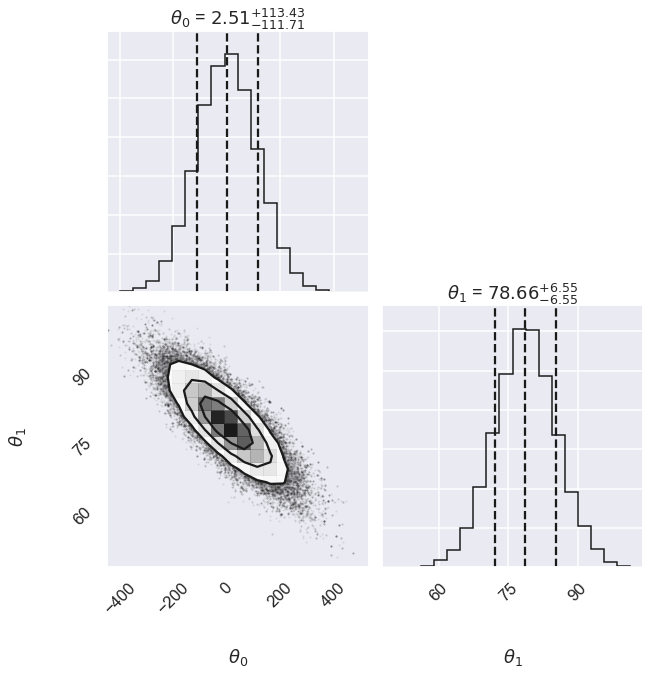

In [19]:
# Alternatively we can use corner
import corner
fig, ax = plt.subplots(2,2, figsize=(10,10))
corner.corner(emcee_trace.T,labels=[r"$\theta_0$", r"$\theta_1$"],
                       quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True
                       );

We can use the parameter samples to create corresponding samples of our model. Finally, we plot the mean and 1-sigma contours of these samples.

In [20]:
def plot_MCMC_model(ax, xdata, ydata, trace, yerr=0):
    """Plot the linear model and 2sigma contours"""
    ax.errorbar(xdata, ydata, yerr, fmt='o')

    alpha, beta = trace[:2]
    xfit = np.linspace(0, 50, 5)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

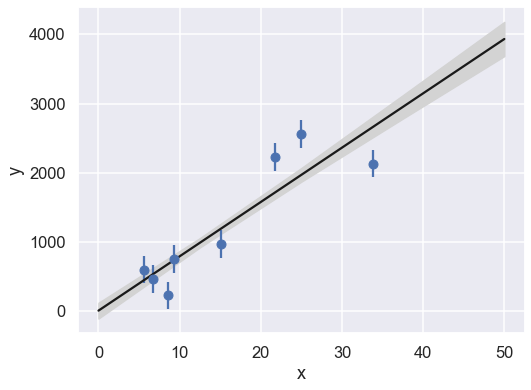

In [23]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
plot_MCMC_model(ax,x,y,emcee_trace,dy)

Caution: 
  - Might we have underestimated the error bars on the experimental data?
  - And/or is some of the data "bad" (are there outliers)?
  
More on this later.

### Summary

In [24]:
print('{0:>25s}: {1:>3.1f} +/- {2:>3.1f}'.format('Max Likelihood (1-sigma)', theta_MLE[1],err_theta_MLE[1]))
print('{0:>25s}: {1:>3.1f} +/- {2:>3.1f}'.format('Fixed offset (1-sigma)',slope_max, err_slope))
print('{0:>25s}: {1:>3.1f} (+{2:>3.1f};-{3:>3.1f})'.format('Full Bayesian (68% CR)',bayesian_slope_mean, bayesian_CR_slope_max-bayesian_slope_mean,bayesian_slope_mean-bayesian_CR_slope_min))


 Max Likelihood (1-sigma): 80.5 +/- 7.4
   Fixed offset (1-sigma): 80.5 +/- 3.8
   Full Bayesian (68% CR): 78.6 (+6.5;-6.7)


### Breakout questions
In the Bayesian analysis we had to specify our prior assumption on the value for the offset.
* *Is this a feature or a deficiency of the Bayesian approach? Discuss!*

What happens if we modify this prior assumption?
* *Redo the analysis with a very broad, uniform prior on the offset. How is the inference affected?*
* *Redo the analysis with a very narrow, normal prior on the offset. How is the inference affected?*

<a id='error_propagation'></a>
## Step 4: Error propagation

The Bayesian approach offers a straight-forward approach for dealing with (known) systematic uncertainties; namely by marginalization.

### Systematic error example
The Hubble constant acts as a galactic ruler as it is used to measure astronomical distances according to $v = H_0 x$. An error in this ruler will therefore correspond to a systematic uncertainty in such measurements.

Suppose that a particular galaxy has a measured recessional velocity $v_\mathrm{measured} = (100 \pm 5) \times 10^3$ km/sec. Also assume that the Hubble constant $H_0$ is known from the analysis performed above in Step 3. Determine the posterior pdf for the distance to the galaxy assuming:
1. A fixed value of $H_0$ corresponding to the mean of the previous analysis.
1. Using the sampled posterior pdf for $H_0$ from the above analysis.

In [25]:
vm=100000
sig_vm=5000

We assume that we can write

$$
   v_\mathrm{measured} = v_\mathrm{theory} + \delta v_\mathrm{exp},
$$

where $v_\mathrm{theory}$ is the recessional velocity according to our model, and $\delta v_\mathrm{exp}$ represents the noise component of the measurement. We know that $\delta v_\mathrm{exp}$ can be described by a Gaussian pdf with mean 0 and standard deviation $\sigma_v = 5 \times 10^3$ km/sec. Note that we have also assumed that our model is perfect, i.e. $\delta v_\mathrm{theory}$ is negligible.

In the following, we also assume that the error in the measurement in $v$ is uncorrelated with the uncertainty in $H_0$.

Through application of Bayes' rule we can readily evaluate the posterior pdf $p(x|D,I)$ for the distance $x$ to the galaxy.

#### Case 1: Fixed $H_0$

\begin{align}
p(x | D,I) & \propto p(D | x, I) p(x|I) \\
& = \frac{1}{\sqrt{2\pi}\sigma_v} \exp \left( - \frac{(v_\mathrm{measured} - v_\mathrm{theory})^2}{2\sigma_v^2} \right) p(x|I)\\
&= \left\{ \begin{array}{ll} \frac{1}{\sqrt{2\pi}\sigma_v} \exp \left( - \frac{(v_\mathrm{measured} - H_0 x)^2}{2\sigma_v^2} \right) & \text{with }x \in [x_\mathrm{min},x_\mathrm{max}] \\
0 & \text{otherwise},
\end{array} \right.
\end{align}

where $p(x|I)$ is the prior for the distance, which we have assumed to be uniform, i.e. $p(x|I) \propto 1$ in some (possibly large) region $[x_\mathrm{min},x_\mathrm{max}]$.

In [26]:
def x_with_fixedH(x,H0,vmeasured=vm,vsigma=sig_vm,xmin=0,xmax=10000):
    # Not including the prior
    x_posterior = np.exp(-(vmeasured-H0*x)**2/(2*vsigma**2))
    return x_posterior

#### Case 2: Using the inferred pdf for $H_0$

Here we use marginalization to obtain the desired posterior pdf $p(x|D,I)$ from the joint distribution of $p(x,H_0|D,I)$

$$
p(x|D,I) = \int_{-\infty}^\infty dH_0 p(x,H_0|D,I).
$$

Using Bayes' rule, the product rule, and the fact that $H_0$ is independent of $x$ we find that

$$
p(x|D,I) \propto p(x|I) \int dH_0 p(H_0|I) p(D|x,H_0,I),
$$

which means that we have expressed the quantity that we want (the posterior for $x$) in terms of quantities that we know.

The pdf $p(H_0 | I)$ is known via its $N$ samples $\{H_{i}\}$ generated by the MCMC sampler.

This means that we can approximate 

$$
p(x |D,I) = \int dH_0 p(H_0|I) p(D|x,H_0,I) \approx \frac{1}{N} \sum_{i=1}^N p(D | x, H_0^{(i)}, I)
$$

where we have used $p(x|I) \propto 1$ and where $H_0^{(i)}$ is drawn from $p(H_0|I)$.

In [27]:
x_arr = np.linspace(800,2000,1200)

xposterior_fixedH = x_with_fixedH(x_arr,bayesian_slope_mean)
xposterior_fixedH /= np.sum(xposterior_fixedH)

xposterior_pdfH = np.zeros_like(x_arr)
for H0 in slope_samples:
    xposterior_pdfH += x_with_fixedH(x_arr,H0)
xposterior_pdfH /= np.sum(xposterior_pdfH)

The mean and 68% DoB of the inferred distance is
... Case 1: x_mean = 1271; 68% DoB [-63,+64]
... Case 2: x_mean = 1281; 68% DoB [-117,+137]


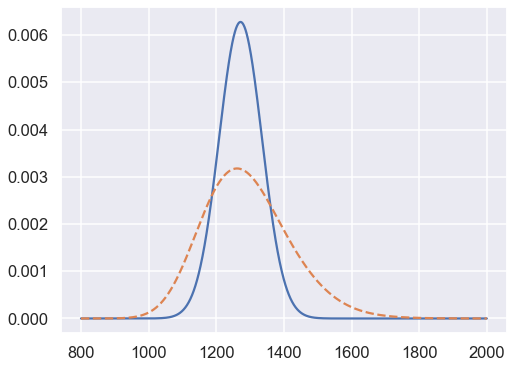

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(x_arr,xposterior_fixedH);
ax.plot(x_arr,xposterior_pdfH,'--');

print("The mean and 68% DoB of the inferred distance is")
for ix, xposterior in enumerate([xposterior_fixedH,xposterior_pdfH]):
    # Mean
    x_mean = np.min(x_arr[np.cumsum(xposterior)>0.5])
    # 68% DoB
    x_min = np.min(x_arr[np.cumsum(xposterior)>0.16])
    x_max = np.min(x_arr[np.cumsum(xposterior)>0.84])
    print(f"... Case {ix+1}: x_mean = {x_mean:.0f}; 68% DoB [-{x_mean-x_min:.0f},+{x_max-x_mean:.0f}]")